In [24]:
import tensorflow as tf
from tensorflow.contrib import slim

import numpy as np

from PIL import Image
from matplotlib import gridspec
from matplotlib import pyplot as plt
%matplotlib inline

In [20]:
log_dir = '/Users/nikki/Desktop/models/research/deeplab/graph/1/'
model_dir_path = '/Users/nikki/Development/deeplab-img-segmentation/model_graph/deeplabv3_pascal_train_aug/'

LABEL_NAMES = np.asarray([
    'background', 'aeroplane', 'bicycle', 'bird', 'boat', 'bottle', 'bus',
    'car', 'cat', 'chair', 'cow', 'diningtable', 'dog', 'horse', 'motorbike',
    'person', 'pottedplant', 'sheep', 'sofa', 'train', 'tv'
])

In [21]:
class DeepLab(object):
    INPUT_TENSOR_NAME = 'ImageTensor:0'
    OUTPUT_TENSOR_NAME = 'SemanticPredictions:0'
    INPUT_SIZE = 513

    def __init__(self):
        self.graph = tf.Graph()

        file = open(model_dir_path + 'frozen_inference_graph.pb', mode='rb')
        graph_def = tf.GraphDef.FromString(file.read())
        file.close()

        if graph_def is None:
            raise RuntimeError('Cannot find inference graph.')

        graph_def = tf.graph_util.extract_sub_graph(graph_def,
                                                    dest_nodes=['xception_65/Pad', 'ResizeBilinear_2', 'ImageTensor', 'SemanticPredictions'])

        with self.graph.as_default():
            tf.import_graph_def(graph_def, name='')

        self.sess = tf.Session(graph=self.graph)


    def run(self, image):
        width, height = image.size
        resize_ratio = 1.0 * self.INPUT_SIZE / max(width, height)
        target_size = (int(resize_ratio * width), int(resize_ratio * height))
        resized_image = image.convert('RGB').resize(target_size, Image.ANTIALIAS)
        batch_seg_map = self.sess.run(
            self.OUTPUT_TENSOR_NAME,
            feed_dict={self.INPUT_TENSOR_NAME: [np.asarray(resized_image)]})
        seg_map = batch_seg_map[0]
        return resized_image, seg_map

    def save_graph(self):
        writer = tf.summary.FileWriter(logdir=log_dir+'my_net', graph=self.graph)

In [245]:
image = Image.open('/Users/nikki/Development/deeplab-img-segmentation/images/2.jpg')
deeplab = DeepLab()
resized_img, seg_map = deeplab.run(image)

In [194]:
def create_color_map(num_labels):
    colormap = np.zeros((num_labels, 3), dtype=np.uint8)
    for i in range(num_labels):
        colormap[i, :] = i * 5
    return colormap

In [249]:
def visualize_seg(image, seg_map):
    color_map = create_color_map(len(LABEL_NAMES))
    
    plt.figure(figsize=(20, 5))

    plt.subplot(141)
    plt.imshow(image)
    plt.axis('off')
    
    plt.subplot(142)
    plt.imshow(image)
    plt.imshow(color_map[seg_map], alpha=0.8)
    plt.axis('off')
    
    plt.subplot(143)
    plt.imshow(color_map[seg_map])
    plt.axis('off')
    
    unique_labels = np.unique(seg_map)
    plt.subplot(144)
    plt.imshow([color_map[unique_labels]], interpolation='nearest')
    plt.xticks(range(len(unique_labels)), LABEL_NAMES[unique_labels])
    plt.grid('off')

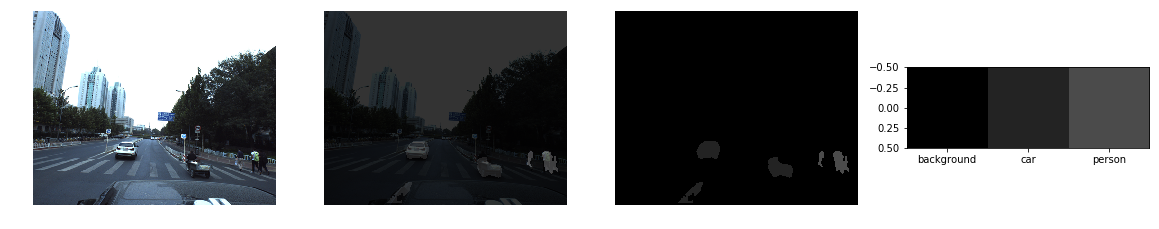

In [250]:
visualize_seg(resized_img, seg_map)